# Mountaincar Environment
* Eval can start anywhere from left to goal state, vel 0 (also training). They need 71 episodes
* Modify cartpole to only have two actions-> left and right. The magnitude of the actions are much larger in nfq paper
* Hint to goal, which sometimes makes the agent perform worse
* Group: the magnitude of the action
* Made the forces symmetric

In [1]:
import configargparse
import torch
import torch.optim as optim
import sys
sys.path.append('../')

from environments import MountainCarEnv, Continuous_MountainCarEnv
from models.agents import NFQAgent
from models.networks import NFQNetwork, ContrastiveNFQNetwork
from util import get_logger, close_logger, load_models, make_reproducible, save_models
import matplotlib.pyplot as plt
import numpy as np
import itertools
import seaborn as sns
import tqdm

# Running experiments

## "Structureless Test"
* The dynamics of the systems are actually the same. Do any of the algorithms learn a difference?

0


  0%|          | 1/1501 [00:02<50:13,  2.01s/it]

Evaluation bg: [0, 0, 0, 0, 0] Evaluation fg: [0, 0, 0, 0, 0]


 20%|██        | 301/1501 [01:08<09:07,  2.19it/s]

Evaluation bg: [0, 0, 0, 0, 0] Evaluation fg: [0, 0, 0, 0, 0]


 40%|████      | 601/1501 [02:18<06:35,  2.27it/s]

Evaluation bg: [0, 0, 0, 0, 0] Evaluation fg: [0, 0, 0, 0, 0]


 60%|██████    | 901/1501 [04:25<08:24,  1.19it/s]

Evaluation bg: [0, 0, 0, 0, 0] Evaluation fg: [0, 0, 0, 0, 0]


 80%|████████  | 1201/1501 [06:37<04:18,  1.16it/s]

Evaluation bg: [0, 0, 0, 0, 0] Evaluation fg: [0, 0, 0, 0, 0]


100%|██████████| 1501/1501 [07:54<00:00,  3.16it/s]

Evaluation bg: [0, 0, 0, 0, 0] Evaluation fg: [0, 0, 0, 0, 0]


Evaluation bg: 0.0 Evaluation fg: 0.0
1


  0%|          | 1/1501 [00:00<24:30,  1.02it/s]

Evaluation bg: [0, 0, 0, 0, 0] Evaluation fg: [0, 0, 0, 0, 0]


 20%|██        | 301/1501 [04:04<27:12,  1.36s/it]

Evaluation bg: [0, 0, 0, 0, 0] Evaluation fg: [0, 0, 0, 0, 0]


 40%|████      | 601/1501 [08:16<20:51,  1.39s/it]

Evaluation bg: [0, 0, 0, 0, 0] Evaluation fg: [0, 0, 0, 0, 0]


 60%|██████    | 901/1501 [10:49<06:55,  1.44it/s]

Evaluation bg: [0, 0, 0, 0, 0] Evaluation fg: [0, 0, 0, 0, 0]


 80%|████████  | 1201/1501 [14:32<07:05,  1.42s/it]

Evaluation bg: [0, 0, 0, 0, 0] Evaluation fg: [0, 0, 0, 0, 0]


100%|██████████| 1501/1501 [18:46<00:00,  1.33it/s]

Evaluation bg: [0, 0, 0, 0, 0] Evaluation fg: [0, 0, 0, 0, 0]


Evaluation bg: 0.0 Evaluation fg: 0.0
2


  0%|          | 1/1501 [00:01<44:44,  1.79s/it]

Evaluation bg: [0, 0, 0, 0, 0] Evaluation fg: [0, 0, 0, 0, 0]


 20%|██        | 301/1501 [02:14<16:48,  1.19it/s]

Evaluation bg: [0, 0, 0, 0, 0] Evaluation fg: [0, 0, 0, 0, 0]


 40%|████      | 601/1501 [03:36<06:33,  2.29it/s]

Evaluation bg: [0, 0, 0, 0, 0] Evaluation fg: [0, 0, 0, 0, 0]


 58%|█████▊    | 873/1501 [05:11<03:44,  2.80it/s]

FREEZING SHARED
FG Trained


Evaluation bg: 100.0 Evaluation fg: 100.0
3


  0%|          | 1/1501 [00:00<14:46,  1.69it/s]

Evaluation bg: [100, 100, 100, 100, 100] Evaluation fg: [100, 100, 100, 100, 100]


  2%|▏         | 24/1501 [00:10<10:37,  2.32it/s]

FREEZING SHARED
FG Trained


Evaluation bg: 100.0 Evaluation fg: 100.0
4


  0%|          | 2/1501 [00:00<09:44,  2.57it/s]

Evaluation bg: [100, 100, 100, 100, 100] Evaluation fg: [100, 100, 100, 100, 100]


 13%|█▎        | 196/1501 [01:25<09:28,  2.30it/s]

FREEZING SHARED
FG Trained


Evaluation bg: 100.0 Evaluation fg: 100.0
5


  0%|          | 1/1501 [00:01<44:54,  1.80s/it]

Evaluation bg: [0, 0, 0, 0, 0] Evaluation fg: [0, 0, 0, 0, 0]


  7%|▋         | 108/1501 [00:48<10:19,  2.25it/s]


FG Trained
Evaluation bg: 68.0 Evaluation fg: 52.0
6


  0%|          | 1/1501 [00:01<44:45,  1.79s/it]

Evaluation bg: [0, 0, 0, 0, 0] Evaluation fg: [0, 0, 0, 0, 0]


  0%|          | 5/1501 [00:03<16:29,  1.51it/s]

FREEZING SHARED
FG Trained


Evaluation bg: 100.0 Evaluation fg: 100.0
7


  0%|          | 1/1501 [00:00<10:17,  2.43it/s]

Evaluation bg: [100, 100, 100, 100, 100] Evaluation fg: [100, 100, 100, 100, 100]


 20%|██        | 301/1501 [02:13<17:32,  1.14it/s]

Evaluation bg: [0, 0, 0, 0, 0] Evaluation fg: [0, 0, 0, 0, 0]


 40%|████      | 601/1501 [04:27<12:59,  1.15it/s]

Evaluation bg: [0, 0, 0, 0, 0] Evaluation fg: [0, 0, 0, 0, 0]


 60%|██████    | 901/1501 [06:40<08:39,  1.16it/s]

Evaluation bg: [0, 0, 0, 0, 0] Evaluation fg: [0, 0, 0, 0, 0]


 80%|████████  | 1201/1501 [08:54<04:17,  1.16it/s]

Evaluation bg: [0, 0, 0, 0, 0] Evaluation fg: [0, 0, 0, 0, 0]


100%|██████████| 1501/1501 [11:07<00:00,  2.25it/s]

Evaluation bg: [0, 0, 0, 0, 0] Evaluation fg: [0, 0, 0, 0, 0]


Evaluation bg: 0.0 Evaluation fg: 0.0
8


  0%|          | 1/1501 [00:01<48:48,  1.95s/it]

Evaluation bg: [0, 0, 0, 0, 0] Evaluation fg: [0, 0, 0, 0, 0]


 20%|██        | 301/1501 [02:15<17:14,  1.16it/s]

Evaluation bg: [0, 0, 0, 0, 0] Evaluation fg: [0, 0, 0, 0, 0]


 36%|███▌      | 541/1501 [04:00<07:06,  2.25it/s]

FREEZING SHARED
FG Trained


Evaluation bg: 100.0 Evaluation fg: 92.0
9


  0%|          | 1/1501 [00:01<45:31,  1.82s/it]

Evaluation bg: [0, 0, 0, 0, 0] Evaluation fg: [0, 0, 0, 0, 0]


 20%|██        | 301/1501 [02:16<17:07,  1.17it/s]

Evaluation bg: [0, 0, 0, 0, 0] Evaluation fg: [0, 0, 0, 0, 0]


 40%|████      | 601/1501 [04:30<12:48,  1.17it/s]

Evaluation bg: [0, 0, 0, 0, 0] Evaluation fg: [0, 0, 0, 0, 0]


 60%|██████    | 901/1501 [06:44<08:28,  1.18it/s]

Evaluation bg: [0, 0, 0, 0, 0] Evaluation fg: [0, 0, 0, 0, 0]


 80%|████████  | 1201/1501 [08:58<04:25,  1.13it/s]

Evaluation bg: [0, 0, 0, 0, 0] Evaluation fg: [0, 0, 0, 0, 0]


100%|██████████| 1501/1501 [11:12<00:00,  2.23it/s]

Evaluation bg: [0, 0, 0, 0, 0] Evaluation fg: [0, 0, 0, 0, 0]


Evaluation bg: 0.0 Evaluation fg: 0.0
10


  0%|          | 1/1501 [00:01<45:08,  1.81s/it]

Evaluation bg: [0, 0, 0, 0, 0] Evaluation fg: [0, 0, 0, 0, 0]


  0%|          | 4/1501 [00:02<18:09,  1.37it/s]


FREEZING SHARED
FG Trained
Evaluation bg: 100.0 Evaluation fg: 100.0
11


  0%|          | 2/1501 [00:00<12:16,  2.04it/s]

Evaluation bg: [100, 100, 100, 100, 100] Evaluation fg: [100, 100, 100, 100, 100]


  0%|          | 2/1501 [00:01<12:53,  1.94it/s]

FREEZING SHARED
FG Trained


Evaluation bg: 100.0 Evaluation fg: 100.0
12


  0%|          | 1/1501 [00:01<47:28,  1.90s/it]

Evaluation bg: [0, 0, 0, 0, 0] Evaluation fg: [0, 0, 0, 0, 0]


 20%|██        | 301/1501 [02:14<17:37,  1.13it/s]

Evaluation bg: [0, 0, 0, 0, 0] Evaluation fg: [0, 0, 0, 0, 0]


 40%|████      | 601/1501 [04:27<12:35,  1.19it/s]

Evaluation bg: [0, 0, 0, 0, 0] Evaluation fg: [0, 0, 0, 0, 0]


 49%|████▉     | 739/1501 [05:27<05:37,  2.26it/s]

FREEZING SHARED
FG Trained


Evaluation bg: 100.0 Evaluation fg: 100.0
13


  0%|          | 1/1501 [00:01<44:51,  1.79s/it]

Evaluation bg: [0, 0, 0, 0, 0] Evaluation fg: [0, 0, 0, 0, 0]


 20%|██        | 301/1501 [02:15<17:34,  1.14it/s]

Evaluation bg: [0, 0, 0, 0, 0] Evaluation fg: [0, 0, 0, 0, 0]


 40%|████      | 601/1501 [04:28<12:55,  1.16it/s]

Evaluation bg: [0, 0, 0, 0, 0] Evaluation fg: [0, 0, 0, 0, 0]


 45%|████▍     | 673/1501 [05:00<06:09,  2.24it/s]

FREEZING SHARED
FG Trained


Evaluation bg: 100.0 Evaluation fg: 94.0
14


  0%|          | 1/1501 [00:01<44:43,  1.79s/it]

Evaluation bg: [0, 0, 0, 0, 0] Evaluation fg: [0, 0, 0, 0, 0]


 20%|██        | 301/1501 [02:16<17:42,  1.13it/s]

Evaluation bg: [0, 0, 0, 0, 0] Evaluation fg: [0, 0, 0, 0, 0]


 40%|████      | 601/1501 [04:30<13:07,  1.14it/s]

Evaluation bg: [0, 0, 0, 0, 0] Evaluation fg: [0, 0, 0, 0, 0]


 60%|██████    | 901/1501 [06:44<08:36,  1.16it/s]

Evaluation bg: [0, 0, 0, 0, 0] Evaluation fg: [0, 0, 0, 0, 0]


 80%|████████  | 1201/1501 [08:58<04:20,  1.15it/s]

Evaluation bg: [0, 0, 0, 0, 0] Evaluation fg: [0, 0, 0, 0, 0]


100%|██████████| 1501/1501 [11:12<00:00,  2.23it/s]

Evaluation bg: [0, 0, 0, 0, 0] Evaluation fg: [0, 0, 0, 0, 0]


Evaluation bg: 0.0 Evaluation fg: 0.0


/home/amandyam/.conda/envs/research/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/amandyam/.conda/envs/research/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'Dynamics are the same in fg and bg environments')

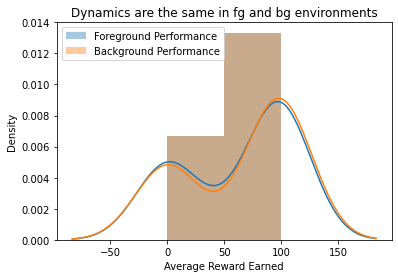

In [3]:
import json
from train_mountaincar import fqi, warm_start, transfer_learning
num_iter=15
perf_foreground = []
perf_background = []
for i in range(num_iter):
    print(str(i))
    perf_bg, perf_fg = fqi(epoch=1500, gravity=0.0025, verbose=True, is_contrastive=True, structureless=True)
    perf_foreground.append(perf_fg)
    perf_background.append(perf_bg)
sns.distplot(perf_foreground, label='Foreground Performance')
sns.distplot(perf_background, label='Background Performance')
plt.legend()
plt.xlabel("Average Reward Earned")
plt.title("Dynamics are the same in fg and bg environments")

## "Performance when force left is different"
* We change the gravity on the foreground environments. 